In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Import the impactor flux and energy data:

In [2]:
imp_flux_energy = pd.read_csv('../fluxes-2024-all_EDITED.csv')#.dropna(axis=1, how='all')

Import decameter impactor file:

In [6]:
# we define decameter impactors to be between 7.5 and 25 meters in diameter
# range of sizes (diameter in meters) we consider to be in the decameter regime
decameter_lb = 7.5  # lower bound
decameter_ub = 25.  # upper bound

# read file containing all impactors, no need to define columns since pandas reads this fine
all_impactors = pd.read_csv('../JPL-website-Oct19-2022-ORBITS-radiants-wspeeds-decameter-impactors-GOOD (1)_EDITED.csv', header='infer')
# filtering to only include those of decameter size (diameter is within some size range)
decameter_impactors = all_impactors.loc[(decameter_lb < all_impactors['Diameter (rho = 1500 kgm-3)']) & 
                                        (all_impactors['Diameter (rho = 1500 kgm-3)'] < decameter_ub)]

Compute our estimate of meteoroid flux vs. energy, with $x$ and $y$ uncertainties:

In [82]:
# get minimum and maximum impact energy of all decameter events
energy_lb = np.min(decameter_impactors['Calculated Total Impact Energy(kt)'])
energy_ub = np.max(decameter_impactors['Calculated Total Impact Energy(kt)'])
# average_energy
mean_energy = np.exp(np.mean(np.log(decameter_impactors['Calculated Total Impact Energy(kt)'])))
# get number of events and meteoroid flux as the number of events divided by the time (30 years)
n_events = len(decameter_impactors)
n_years = 30  # 1994-01-01 to 2024-01-01
# flux estimate, in impacts/year
flux = n_events/n_years
# y uncertainty should have 2 components: 
# first, compute the uncertainty in bulk density (ranging from 1500 to 3400 kg/m^3, 
# since we are assuming a constant bulk density for all objects in our work

def get_diameter(v, impact_e, rho):
    """
    Get the meteoroid diameter in m as a function of meteoroid velocity v in km/s, 
    impact energy impact_e in kT of TNT and bulk density rho in kg/m^3
    according to the formulae in the decameter impactors sheet
    """
    # compute the meteoroid mass, converting units as needed
    m = (impact_e * 4.18e12 * 2)/((v * 1000) ** 2)
    # compute the meteoroid diameter using bulk density rho, assuming sphere
    diameter = 2 * ((m/(4 * rho)) ** (1/3))
    # return
    return diameter

def get_energy(v, diameter, rho):
    """
    Get the meteoroid energy in kT of TNT as a function of meteoroid diameter in m, 
    velocity v in km/s and bulk density rho in kg/m^3
    """
    # compute mass
    m = 4 * rho * (diameter/2) ** 3
    # compute energy
    impact_e = (((v * 1000) ** 2) * m)/(2 * 4.18e12)
    # return
    return impact_e

# get velocities and energies of decameter impactors
vs, energies = np.array(decameter_impactors[['Vel(km/s)', 'Calculated Total Impact Energy(kt)']]).T
# compute diameters of impactors for rho = 1500 and rho = 3400 kg/m^3
diameter_1500 = get_diameter(vs, energies, rho=1500.)
diameter_3400 = get_diameter(vs, energies, rho=3400.)
# count the number of decameter impactors for the low and the high values of rho
n_impactors_1500 = np.sum((decameter_lb < diameter_1500) & (diameter_1500 < decameter_ub))
n_impactors_3400 = np.sum((decameter_lb < diameter_3400) & (diameter_3400 < decameter_ub))
# the upper and lower bounds are therefore the number of impactors per year
flux_density_lb = n_impactors_3400/n_years
flux_density_ub = n_impactors_1500/n_years
# statistical uncertainty; 1-sigma uncertainty for Poisson distribution with lambda = n_events
# assume the observed flux is the true, "expected" rate of impacts. The standard deviation is then sqrt(lambda)
# with the 1-sigma uncertainty being lambda +- sqrt(lambda)
flux_poisson_lb = flux - np.sqrt(flux)
flux_poisson_ub = flux + np.sqrt(flux)

Get the Nesvorny 2023, Harris and Chodas 2021, Heinze et al. 2021 data using WebDigitizer from the Nesvorny et al. 2023 paper. Note that the Granvik et al. 2018 data cuts off just before the decameter range:

In [83]:
nesvorny_H, nesvorny_n = np.array([(25.00454573681032, 398206.1932492405), (25.994304396341576, 1445041.4413835285), 
                                (26.49601530199467, 2556480.9239126523), (25.500777836389062, 796854.4162551889), 
                                (27.00038672623175, 4553815.72008523), (27.49804032663232, 8022129.076258822), 
                                (28.009245800031795, 13670443.384151407)]).T
hc_H, hc_n = np.array([(25.003124235988494, 452339.78821174765), (25.50038267028103, 962007.301428928), 
                       (25.997908422823123, 1801179.8030262566), (26.502140376669132, 3428943.546172533), 
                       (26.999375565896496, 7373703.00650031), (27.496506152330557, 16667241.41561274), 
                       (27.993729719025335, 36040839.34683729), (28.497705977154382, 77504545.97920467)]).T
heinze_H, heinze_n = np.array([(24.996685352934122, 391656.5071032797), (25.500894061714952, 753911.4538853763), 
                               (25.998710377571772, 1229001.5638882718), (26.50232633719056, 3138098.0358426133), 
                               (26.999782354537118, 6074078.394066023), (27.49687807337341, 13959699.514464786), 
                               (27.9944038259155, 26136941.772085987)]).T

# use the equation from https://cneos.jpl.nasa.gov/tools/ast_size_est.html to compute diameter from albedo and H, using a = 0.18 from the NEOMOD model
a = 0.18  # constant from the NEOMOD model
get_diameter = lambda H, a=a: 10 ** (3.1236 - 0.5 * np.log10(a) - 0.2 * H)
# compute diameter and then convert from km to m
nesvorny_diameter = get_diameter(nesvorny_H) * 1000.
hc_diameter = get_diameter(hc_H) * 1000.
heinze_diameter = get_diameter(heinze_H) * 1000.

Assume $v = 20$ km/s and $\rho = 1500$ for all of them to compute (potential) impact energies:

In [85]:
v0 = 20  # in km/s
rho0 = 1500  # in kg/m^3
# compute
nesvorny_es = get_energy(v0, nesvorny_diameter, rho0)
hc_es = get_energy(v0, hc_diameter, rho0)
heinze_es = get_energy(v0, heinze_diameter, rho0)

For each set of impactor energies and fluxes, plot as a separate series with a separate colour in matplotlib:

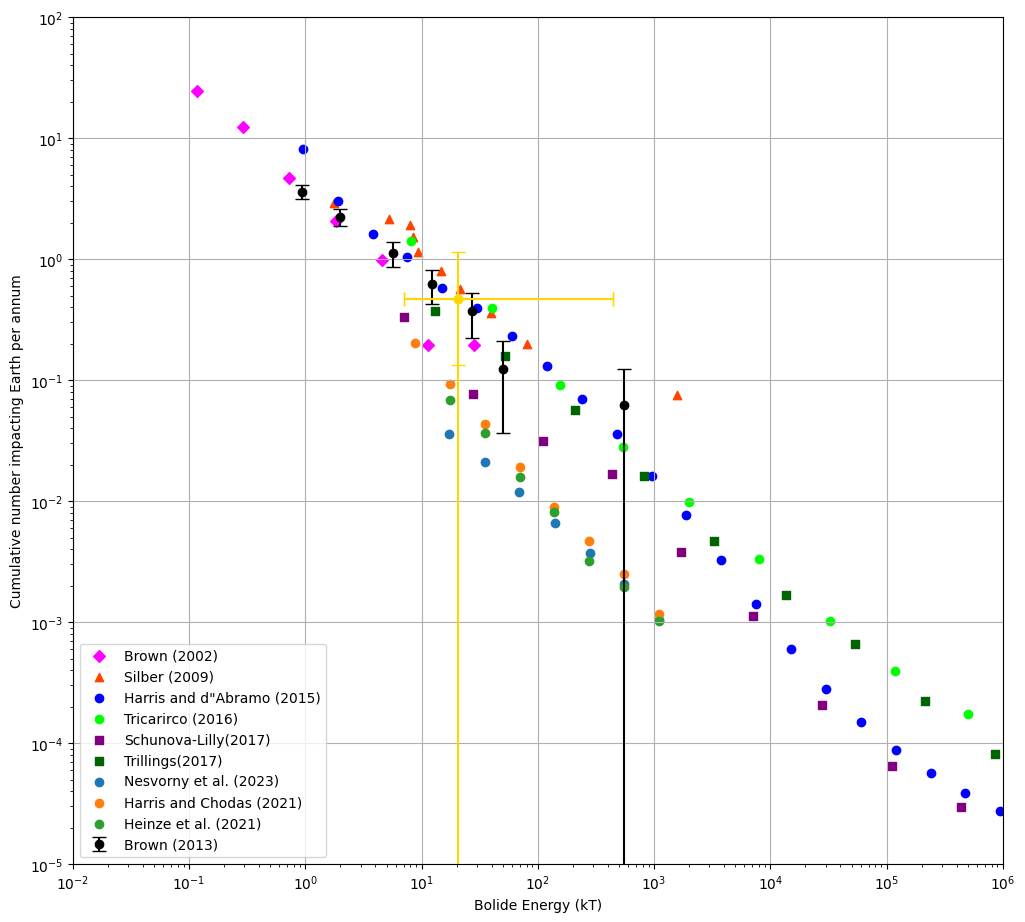

In [93]:
# get index of all the columns with energy
energy_indices = [imp_flux_energy.columns.get_loc(col) for col in imp_flux_energy.columns if 'Energy (kT)' in col]
# same colours/markers as in the original image
colours = ['fuchsia', 'orangered', 'black', 'blue', 'lime', 'purple', 'darkgreen']
markers = ['D', '^', 'o', 'o', 'o', 's', 's']

# plot figure
plt.figure(figsize = (12, 11))
for j, ind in enumerate(energy_indices):
    # plot energy in the energy index against the flux (impacts per year), in the following column, for each set of impactors
    # plot errorbars if given
    try:
        if 'err' in imp_flux_energy.columns[ind + 2]:
            plt.errorbar(imp_flux_energy.iloc[:,ind], imp_flux_energy.iloc[:, ind + 1], 
                         yerr = imp_flux_energy.iloc[:, ind + 2], label = imp_flux_energy.columns[ind + 1], 
                         fmt=markers[j], capsize=5, c=colours[j])#c=f'C{energy_indices.index(ind)}')
        else:
            plt.scatter(imp_flux_energy.iloc[:,ind], imp_flux_energy.iloc[:, ind + 1], 
                        label = imp_flux_energy.columns[ind + 1], c=colours[j], marker=markers[j])
    except: 
        # otherwise just normal scatter
        plt.scatter(imp_flux_energy.iloc[:,ind], imp_flux_energy.iloc[:, ind + 1], 
                    label = imp_flux_energy.columns[ind + 1], c=colours[j], marker=markers[j])
# plot the nesvorny, harris and chodas, and heinze points:
plt.scatter(nesvorny_es, nesvorny_n * 2.6e-9, label = 'Nesvorny et al. (2023)')
plt.scatter(hc_es, hc_n * 2.6e-9, label = 'Harris and Chodas (2021)')
plt.scatter(heinze_es, heinze_n * 2.6e-9, label = 'Heinze et al. (2021)')
# add our point!
# uncertainty introduced by bulk density
plt.errorbar(mean_energy, flux, yerr=np.array([flux - flux_density_lb, flux_density_ub - flux])[:, None], 
             xerr=np.array([mean_energy - energy_lb, energy_ub - mean_energy])[:, None], fmt='o', capsize=5, c='gold')
# statistical uncertainty
plt.errorbar(mean_energy, flux, yerr=np.sqrt(flux), 
             xerr=np.array([mean_energy - energy_lb, energy_ub - mean_energy])[:, None], fmt='o', capsize=5, c='gold')
# log scale
plt.xscale('log'), plt.yscale('log')
# set xlim, ylim to same values used in figure
xmin, xmax = 1e-2, 1e6
ymin, ymax = 1e-5, 1e2
# x, ylim
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
# label axes
plt.xlabel('Bolide Energy (kT)')
plt.ylabel('Cumulative number impacting Earth per annum')
# set x, y ticks
plt.xticks(ticks=np.geomspace(xmin, xmax, int(np.log10(xmax) - np.log10(xmin) + 1)), minor=False)
plt.yticks(ticks=np.geomspace(ymin, ymax, int(np.log10(ymax) - np.log10(ymin) + 1)), minor=False)
# show grid
plt.grid()
# legend
plt.legend(loc='lower left')
plt.savefig('impactor_flux_energy.png')